# FSK Modulation and Demodulation

FSK modulation varies the frequency of a signal to modulate information, and can be demodulated using techniques such as a Goertzel filter. FSK is insensitive to non-frequency-dependent amplitude variations.

In [1]:
import numpy as np
from scipy import signal
from scipy.integrate import cumtrapz

import matplotlib.pyplot as plt

In [2]:
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

## Modulation

We use coherent FSK modulation to prevent discontinuities when the frequency changes. To accomplish this, we view frequency as the derivative of phase, first constructing the list of frequencies, and then integrating it over time to get the instantaneous phase.

In [3]:
timesequence=np.linspace(0,4,4001)
fs=1/(timesequence[1]-timesequence[0])
frequencies=4*np.heaviside(timesequence-2,0.5)+2
phases=cumtrapz(frequencies,timesequence,initial=0)
phases*=2*np.pi
output_signal=np.cos(phases)

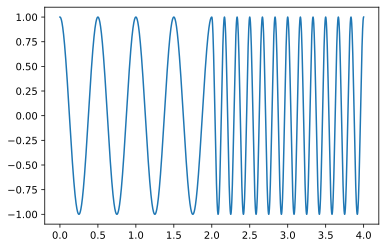

In [4]:
plt.plot(timesequence,np.cos(phases))
plt.show()

We also do amplitude shaping at the ends by padding the ends with a 0-frequency dummy symbol and performing Gaussian smoothing on the amplitude to prevent discontinuity at the ends of the modulated signal.

## Demodulation

To perform demodulation, we construct a Goertzel filter, tuned to the desired frequency. The form of the Goertzel filter (taken from https://www.dsprelated.com/showarticle/796.php) is

\begin{align*}
H_G(z) &= \frac{1}{1-e^{2\pi jf}z^{-1}} \cdot \frac{1-e^{-2\pi jf}z^{-1}}{1-e^{-2\pi jf}z^{-1}} \\
&= \frac{1-e^{-2\pi jf}z^{-1}}{1-2\cos(2\pi f)z^{-1}+z^{-2}}
\end{align*}

We use this form (which has complex-conjugate poles and a zero to cancel out the bottom pole) to improve numerical stability, as explained in the linked article above.

In [5]:
def goertzel_iir(freq,fs):
    if freq>=0.5*fs:
        raise ValueError("Desired peak frequency is too high")
    norm_freq=2*np.pi*freq/fs
    numerator=[1,-np.exp(-1j*norm_freq)]
    denominator=[1,-2*np.cos(norm_freq),1]
    return (numerator,denominator)

In [6]:
goertzel_two=goertzel_iir(2,fs)
goertzel_four=goertzel_iir(4,fs)
goertzel_six=goertzel_iir(6,fs)

We plot the frequency responses of the filters:

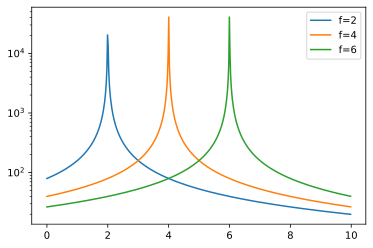

In [7]:
freq_sample=np.linspace(0, 10, 512, endpoint=False)
freq_two,resp_two=signal.freqz(*goertzel_two,worN=freq_sample,fs=fs)
freq_four,resp_four=signal.freqz(*goertzel_four,worN=freq_sample,fs=fs)
freq_six,resp_six=signal.freqz(*goertzel_six,worN=freq_sample,fs=fs)
plt.semilogy(freq_two,np.abs(resp_two))
plt.semilogy(freq_four,np.abs(resp_four))
plt.semilogy(freq_six,np.abs(resp_six))
plt.legend(["f=2","f=4","f=6"])
plt.show()

In order to perform the demodulation, we divide the modulated signal into symbol blocks, filter each block through Goertzel filters tuned to each frequency, and compare the absolute values of the last output of each filter.

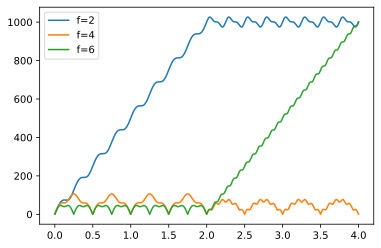

In [8]:
plt.plot(timesequence,np.abs(signal.lfilter(*goertzel_two,output_signal)))
plt.plot(timesequence,np.abs(signal.lfilter(*goertzel_four,output_signal)))
plt.plot(timesequence,np.abs(signal.lfilter(*goertzel_six,output_signal)))
plt.legend(["f=2","f=4","f=6"])
plt.show()